In [1]:
# Do analyst recommendations correlate with stock performance?
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import sqlite3
pd.set_option('display.max_columns',500)

In [2]:
stock_ticker='AMZN'
period = '5y'
stock=yf.Ticker(stock_ticker)

In [3]:
history=stock.history(period=period)
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-13,831.619995,843.000000,828.549988,836.530029,4172600,0,0
2017-02-14,837.000000,838.309998,831.450012,836.390015,2792400,0,0
2017-02-15,834.000000,842.809998,832.820007,842.700012,2968900,0,0
2017-02-16,841.840027,845.000000,839.380005,844.140015,2714700,0,0
2017-02-17,842.000000,847.270020,840.729980,845.070007,3112300,0,0
...,...,...,...,...,...,...,...
2022-02-07,3170.399902,3253.820068,3145.000000,3158.709961,5131200,0,0
2022-02-08,3135.010010,3235.850098,3111.010010,3228.270020,3802000,0,0
2022-02-09,3257.469971,3276.689941,3205.000000,3223.790039,3439300,0,0


In [4]:
# Get recommendations
days_out = 180
recommendations=stock.recommendations.reset_index().sort_values(by=['Firm','Date'])
recommendations['Next Recommendation']=recommendations.groupby('Firm')['Date'].shift(-1)
recommendations[str(days_out)+' Days From']=recommendations['Date']+pd.Timedelta(days=days_out)
recommendations['Good Until']=recommendations[['Next Recommendation',str(days_out)+' Days From']].max(axis=1) # Define how long a recommendation lasts for - lowest of [180 days] or [Until a new recommendation by that firm]
recommendations

,Date,Firm,To Grade,From Grade,Action,Next Recommendation,180 Days From,Good Until
200,2017-01-20 14:16:33,Aegis Capital,Buy,,init,2020-02-13 15:47:00,2017-07-19 14:16:33,2020-02-13 15:47:00
340,2020-02-13 15:47:00,Aegis Capital,Buy,,main,NaT,2020-08-11 15:47:00,2020-08-11 15:47:00
247,2018-05-05 13:32:14,Argus,Hold,Buy,down,2018-05-05 13:32:14,2018-11-01 13:32:14,2018-11-01 13:32:14
248,2018-05-05 13:32:14,Argus,Buy,Hold,up,NaT,2018-11-01 13:32:14,2018-11-01 13:32:14
75,2014-04-16 08:04:57,Argus Capital,Buy,Hold,up,NaT,2014-10-13 08:04:57,2014-10-13 08:04:57
...,...,...,...,...,...,...,...,...
435,2021-04-30 14:43:23,Wells Fargo,Overweight,,main,NaT,2021-10-27 14:43:23,2021-10-27 14:43:23
174,2016-06-10 06:14:21,William Blair,Outperform,,init,NaT,2016-12-07 06:14:21,2016-12-07 06:14:21
96,2014-10-13 16:00:00,Wolfe Research,,,main,2015-03-10 09:29:02,2015-04-11 16:00:00,2015-04-11 16:00:00
112,2015-03-10 09:29:02,Wolfe Research,Outperform,Peer Perform,up,2017-04-20 15:54:55,2015-09-06 09:29:02,2017-04-20 15:54:55


In [5]:
print(sorted(recommendations['To Grade'].dropna().unique())) # Print out the unique recommendation grades
assign_values = {'Buy':4, 'Equal-Weight':3, 'Hold':3, 'Market Perform':3, 'Neutral':3,
       'Outperform':4, 'Overweight':4, 'Peer Perform':3, 'Positive':4, 'Reduce':2,
       'Sector Perform':3, 'Sector Weight':3, 'Sell':1, 'Strong Buy':5, 'Underperform':1,
       'Underweight':1} # Create numeric representations of the recommendations
recommendations['Assigned Value']=recommendations['To Grade'].replace(assign_values) # Give the numeric representations a column
recommendations

['', 'Buy', 'Equal-Weight', 'Fair Value', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Sector Weight', 'Sell', 'Strong Buy']


,Date,Firm,To Grade,From Grade,Action,Next Recommendation,180 Days From,Good Until,Assigned Value
200,2017-01-20 14:16:33,Aegis Capital,Buy,,init,2020-02-13 15:47:00,2017-07-19 14:16:33,2020-02-13 15:47:00,4
340,2020-02-13 15:47:00,Aegis Capital,Buy,,main,NaT,2020-08-11 15:47:00,2020-08-11 15:47:00,4
247,2018-05-05 13:32:14,Argus,Hold,Buy,down,2018-05-05 13:32:14,2018-11-01 13:32:14,2018-11-01 13:32:14,3
248,2018-05-05 13:32:14,Argus,Buy,Hold,up,NaT,2018-11-01 13:32:14,2018-11-01 13:32:14,4
75,2014-04-16 08:04:57,Argus Capital,Buy,Hold,up,NaT,2014-10-13 08:04:57,2014-10-13 08:04:57,4
...,...,...,...,...,...,...,...,...,...
435,2021-04-30 14:43:23,Wells Fargo,Overweight,,main,NaT,2021-10-27 14:43:23,2021-10-27 14:43:23,4
174,2016-06-10 06:14:21,William Blair,Outperform,,init,NaT,2016-12-07 06:14:21,2016-12-07 06:14:21,4
96,2014-10-13 16:00:00,Wolfe Research,,,main,2015-03-10 09:29:02,2015-04-11 16:00:00,2015-04-11 16:00:00,
112,2015-03-10 09:29:02,Wolfe Research,Outperform,Peer Perform,up,2017-04-20 15:54:55,2015-09-06 09:29:02,2017-04-20 15:54:55,4


In [6]:
conn = sqlite3.connect(':memory:')
history.to_sql('history', conn, index=True)
recommendations.to_sql('recommendations', conn, index=False)

472

In [7]:
# # Use SQL to join on dates and to create a day column
# # Only keep recommendations for firms with at least 5 recommendations (in the SQL)

# qry = '''
# select h.open, h.high, h.low, h.close, h.volume, r.firm, date(h.date) as Date, 
# --julianday(date(h.date))-julianday('2012-01-01') as 'Day Value', -- not using this column for date axis
# r.action, r.'to grade', r.'from grade', date(r.'good until') as 'Good Until Date',
# --julianday(date(r.'good until'))-julianday('2012-01-01') as 'Good Until Day Value' -- not using this column for date axis
# r.'assigned value'
# from history h
# left join ( 
# select * from recommendations r 
# where r.firm in (select firm from recommendations group by firm having count(date)>=5) -- Join recommendations, but only for firms with at least 5 recommendations
# ) r
# on date(h.date) = date(r.date)
#     '''
# df = pd.read_sql_query(qry, conn).sort_values(by='Date')
# for i in ['Date','Good Until Date']:
#     df[i]=pd.to_datetime(df[i])
# df

In [8]:
# # Make a plot with background color estimating recommendation sentiment for the periods
# # This consider each analyst effect individually with color overlays
# fig,ax = plt.subplots()
# df.plot(figsize=(16,16),x='Date',y=['Close'],ax=ax)
# for idx, row in df[df['Action'].notnull()].iterrows(): # For the dates with analyst activity, give coloring
# #     ax.annotate(row['To Grade'],(row['Date'],row['Close']),rotation=80)
#     if row['Assigned Value'] == '1':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.2,color='red')
#     if row['Assigned Value'] == '2':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.1,color='red')
#     if row['Assigned Value'] == '3':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.05,color='yellow')
#     if row['Assigned Value'] == '4':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.05,color='green')
#     if row['Assigned Value'] == '5':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.1,color='green')
# #     print(row['Assigned Value'])
# plt.show()

In [9]:
# Get average analyst assigned scores by day
qry = '''
select h.open, h.high, h.low, h.close, h.volume, date(h.date) as Date, avg(r.'assigned value') as 'Average Assigned Value'
from history h
left join ( 
select * from recommendations r 
where r.firm in (select firm from recommendations group by firm having count(date)>=5) -- Join recommendations, but only for firms with at least 5 recommendations
) r
on date(h.date) between date(r.date) and date(r.'good until')
group by h.open, h.high, h.low, h.close, h.volume, date(h.date)
    '''
df = pd.read_sql_query(qry, conn).sort_values(by='Date')
for i in ['Date']:
    df[i]=pd.to_datetime(df[i])
df

,Open,High,Low,Close,Volume,Date,Average Assigned Value
0,831.619995,843.000000,828.549988,836.530029,4172600,2017-02-13,3.709677
2,837.000000,838.309998,831.450012,836.390015,2792400,2017-02-14,3.709677
1,834.000000,842.809998,832.820007,842.700012,2968900,2017-02-15,3.709677
5,841.840027,845.000000,839.380005,844.140015,2714700,2017-02-16,3.709677
6,842.000000,847.270020,840.729980,845.070007,3112300,2017-02-17,3.709677
...,...,...,...,...,...,...,...
963,3170.399902,3253.820068,3145.000000,3158.709961,5131200,2022-02-07,3.800000
932,3135.010010,3235.850098,3111.010010,3228.270020,3802000,2022-02-08,3.800000
1048,3257.469971,3276.689941,3205.000000,3223.790039,3439300,2022-02-09,3.800000
959,3167.000000,3214.330078,3155.000000,3180.070068,3413400,2022-02-10,3.800000


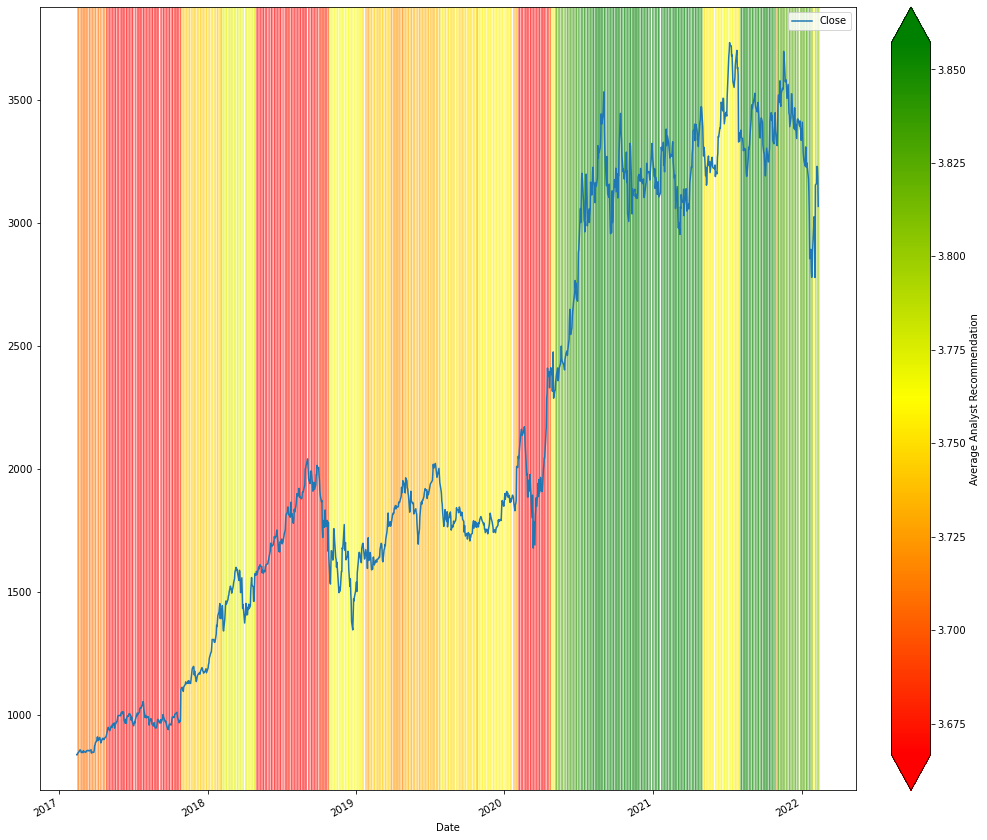

In [10]:
# Make a plot with background color estimating recommendation sentiment for the periods
# This considers the average recommendation overall
fig,ax = plt.subplots()
df.plot(figsize=(16,16),x='Date',y=['Close'],ax=ax)
# # Originally used a list color map but change to a scalar map
colormap=colors.LinearSegmentedColormap.from_list('custom',['Red','Yellow','Green'])
# vmin, vmax = 2.5, 4.5 # Manual color definition
qlow = 0.15
qhigh = 0.85
vmin = df['Average Assigned Value'].quantile(qlow) # Color definition using quantiles (low)
vmax = df['Average Assigned Value'].quantile(qhigh) # Color definition using quantiles (high)
normalize = colors.Normalize(vmin=vmin,vmax=vmax)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
for idx, row in df.iterrows():
    ax.axvspan(row['Date'],row['Date']+pd.DateOffset(days=1),alpha=0.2,color=scalarmappaple.to_rgba(row['Average Assigned Value']))
cbar=plt.colorbar(scalarmappaple,label='Average Analyst Recommendation',extend='both',fraction=0.046, pad=0.04)
plt.show()

In [11]:
df['Returns']=(df['Close']-df['Open'])/df['Open']
df.corr()

,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999658,0.999546,0.999145,-0.079650,0.774813,-0.041443
High,0.999658,1.000000,0.999446,0.999589,-0.070134,0.775404,-0.023383
Low,0.999546,0.999446,1.000000,0.999598,-0.092746,0.773281,-0.020813
Close,0.999145,0.999589,0.999598,1.000000,-0.081554,0.774314,-0.002602
Volume,-0.079650,-0.070134,-0.092746,-0.081554,1.000000,-0.043937,-0.052952
Average Assigned Value,0.774813,0.775404,0.773281,0.774314,-0.043937,1.000000,-0.021579
Returns,-0.041443,-0.023383,-0.020813,-0.002602,-0.052952,-0.021579,1.000000


In [12]:
df['Track Difference Up'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(1),0,1)
df['Track Difference Down'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(-1),0,1)
df['Track Difference Unique'] = df['Track Difference Up'].cumsum()
df['First Open'] = np.where(df['Track Difference Up']==1,df['Open'],None)
df['Last Close'] = np.where(df['Track Difference Down']==1,df['Close'],None)
df

,Open,High,Low,Close,Volume,Date,Average Assigned Value,Returns,Track Difference Up,Track Difference Down,Track Difference Unique,First Open,Last Close
0,831.619995,843.000000,828.549988,836.530029,4172600,2017-02-13,3.709677,0.005904,1,0,1,831.619995,None
2,837.000000,838.309998,831.450012,836.390015,2792400,2017-02-14,3.709677,-0.000729,0,0,1,None,None
1,834.000000,842.809998,832.820007,842.700012,2968900,2017-02-15,3.709677,0.010432,0,0,1,None,None
5,841.840027,845.000000,839.380005,844.140015,2714700,2017-02-16,3.709677,0.002732,0,0,1,None,None
6,842.000000,847.270020,840.729980,845.070007,3112300,2017-02-17,3.709677,0.003646,0,0,1,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,3170.399902,3253.820068,3145.000000,3158.709961,5131200,2022-02-07,3.800000,-0.003687,1,0,201,3170.399902,None
932,3135.010010,3235.850098,3111.010010,3228.270020,3802000,2022-02-08,3.800000,0.029748,0,0,201,None,None
1048,3257.469971,3276.689941,3205.000000,3223.790039,3439300,2022-02-09,3.800000,-0.010339,0,0,201,None,None
959,3167.000000,3214.330078,3155.000000,3180.070068,3413400,2022-02-10,3.800000,0.004127,0,0,201,None,None


In [13]:
returns_df = df.groupby(['Track Difference Unique','Average Assigned Value']).agg({'First Open':'min','Last Close':'max','Returns':'count'}).reset_index()
returns_df['Total Return Fraction']=returns_df['Last Close']/returns_df['First Open']
returns_df['Daily Return']=100*(1-returns_df['Total Return Fraction']**(1/returns_df['Returns']))
returns_df

,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
0,1,3.709677,831.619995,846.820007,30,1.018278,-0.060393
1,2,3.718750,851.750000,856.000000,1,1.004990,-0.498973
2,3,3.709677,859.049988,891.510010,4,1.037786,-0.931551
3,4,3.718750,891.500000,906.830017,1,1.017196,-1.719576
4,5,3.709677,910.820007,898.530029,12,0.986507,0.113146
...,...,...,...,...,...,...,...
196,197,3.826087,2780.000000,2777.449951,3,0.999083,0.030585
197,198,3.750000,2816.000000,2792.750000,1,0.991744,0.825639
198,199,3.764706,2817.209961,2776.909912,5,0.985695,0.287750
199,200,3.818182,3112.129883,3152.790039,1,1.013065,-1.306506


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.707954,0.958520,0.950226,-0.214046,-0.206034,0.288034
Average Assigned Value,0.707954,1.000000,0.757429,0.755790,-0.176504,-0.118568,0.098366
First Open,0.958520,0.757429,1.000000,0.989149,-0.237395,-0.229313,0.294184
Last Close,0.950226,0.755790,0.989149,1.000000,-0.231295,-0.091049,0.171117
Returns,-0.214046,-0.176504,-0.237395,-0.231295,1.000000,0.082949,-0.041346
Total Return Fraction,-0.206034,-0.118568,-0.229313,-0.091049,0.082949,1.000000,-0.883157
Daily Return,0.288034,0.098366,0.294184,0.171117,-0.041346,-0.883157,1.000000


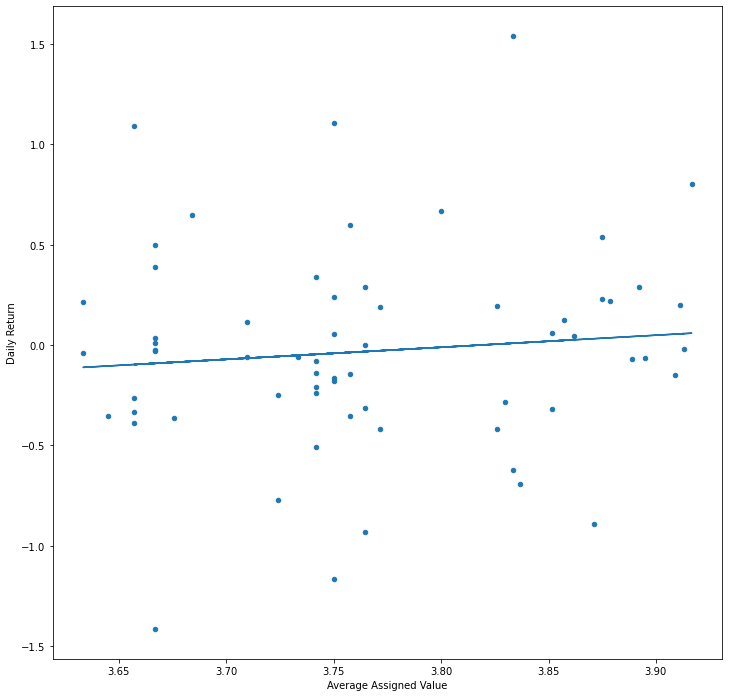

In [14]:
min_returns = 5
min_returns_df = returns_df[returns_df['Returns']>=min_returns]
min_returns_df.plot(x='Average Assigned Value',y='Daily Return',kind='scatter',figsize=(12,12))
m,b = np.polyfit(x=min_returns_df['Average Assigned Value'],y=min_returns_df['Daily Return'], deg=1)
plt.plot(min_returns_df['Average Assigned Value'],min_returns_df['Average Assigned Value']*m+b)
min_returns_df.corr()

In [17]:
returns_df[returns_df['Returns']>min_returns].corr()

,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.724436,0.965586,0.957076,-0.101700,-0.154025,0.206681
Average Assigned Value,0.724436,1.000000,0.763455,0.758761,-0.107006,-0.091049,0.055780
First Open,0.965586,0.763455,1.000000,0.987777,-0.141698,-0.182025,0.217106
Last Close,0.957076,0.758761,0.987777,1.000000,-0.139759,-0.034262,0.084730
Returns,-0.101700,-0.107006,-0.141698,-0.139759,1.000000,0.036900,0.036340
Total Return Fraction,-0.154025,-0.091049,-0.182025,-0.034262,0.036900,1.000000,-0.885739
Daily Return,0.206681,0.055780,0.217106,0.084730,0.036340,-0.885739,1.000000


In [16]:
returns_df.corr()

,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.707080,0.950223,0.948281,-0.098621,-0.089140,0.029185
Average Assigned Value,0.707080,1.000000,0.778118,0.778429,-0.089418,-0.044965,-0.040093
First Open,0.950223,0.778118,1.000000,0.993806,-0.113722,-0.129958,0.077344
Last Close,0.948281,0.778429,0.993806,1.000000,-0.107222,-0.024152,0.007041
Returns,-0.098621,-0.089418,-0.113722,-0.107222,1.000000,0.113984,0.004047
Total Return Fraction,-0.089140,-0.044965,-0.129958,-0.024152,0.113984,1.000000,-0.640472
Daily Return,0.029185,-0.040093,0.077344,0.007041,0.004047,-0.640472,1.000000
